# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Import required libraries**

In [2]:
import numpy as np
import os
import datetime
from PIL import Image
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow.keras import backend as k
#tf.set_random_seed(30)
tf.random.set_seed(30)
import matplotlib.pyplot as plt
%matplotlib inline

**Below files contain the folder names for training and validation**

In [3]:
train_doc = np.random.permutation(open('/content/drive/My Drive/dataset_colab/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/dataset_colab/Project_data/val.csv').readlines())

In [ ]:
train_doc[:10]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'],
      dtype='<U88')

**Take a look at any one of the training folders picked up randomly**

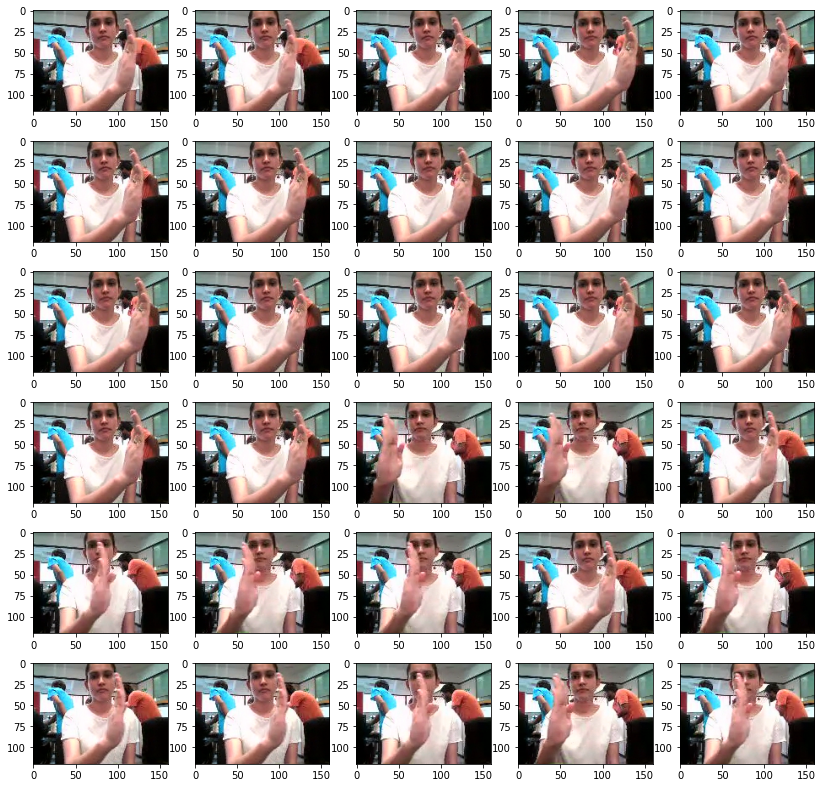

In [ ]:
source_path = '/content/drive/My Drive/dataset_colab/Project_data/train'
t = np.random.permutation(train_doc)

imgs = os.listdir(source_path+'/'+ t[0].split(';')[0])

plt.figure(figsize=(14, 14))

for i,v in enumerate(imgs):
    plt.subplot(6,5,i+1)
    image = Image.open(source_path+'/'+ t[0].strip().split(';')[0]+'/'+v)
    plt.imshow(image)

### Generator construction

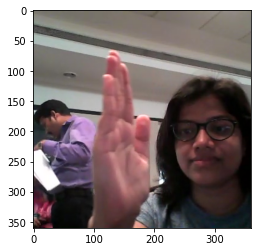

In [ ]:
img = Image.open('/content/drive/My Drive/dataset_colab/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00056.png')
plt.imshow(img)

In [ ]:
pic_arr = np.asarray(img)
pic_arr.shape

(360, 360, 3)

In [4]:
#Let's take image size as 120x120
img_size = 120

#batch size as 32 
batch_size = 32

#Pickup images having below indexes from folder of 30 images for each frame -
img_idx = [i for i in range(2,30,2)]
print(len(img_idx))

14


In [5]:
#Preprocess images - center-Crop and resize -
def img_preprocess(img):
    img_arr = np.asarray(img)
    h,w = img_arr.shape[:2]
    x=0
    y=0
    
    crop_image = img_arr[x+20:h-20, y+20:w-20,:]
    
    img = Image.fromarray(crop_image) 
    
    new_img = img.resize((img_size,img_size), Image.ANTIALIAS)
    
    new_img = np.asarray(new_img)
    
    new_img = new_img.astype(np.float32)   #this is required is it has to be converted to float
    
    return(new_img)

video is represented the generator below as (number of images, height, width, number of channels)

In [6]:
#Generator function -
def generator(source_path, folder_list, batch_size,img_idx,shuffle=True):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        if shuffle == True:
            t = np.random.permutation(folder_list)
        else:
            t = folder_list
        
        num_batches = len(t)//batch_size  # calculate the number of batches 
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            #x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3))
            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                    ges_image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    ges_image = img_preprocess(ges_image)
                    
                    batch_data[folder,idx,:,:,0] = (ges_image[:,:,0] - np.min(ges_image[:,:,0]))/(np.max(ges_image[:,:,0]) - np.min(ges_image[:,:,0]))  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (ges_image[:,:,1] - np.min(ges_image[:,:,1]))/(np.max(ges_image[:,:,1]) - np.min(ges_image[:,:,1]))  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (ges_image[:,:,2] - np.min(ges_image[:,:,2]))/(np.max(ges_image[:,:,2]) - np.min(ges_image[:,:,2]))  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem = len(t)%batch_size
        if (rem != 0):           
            batch_size = rem
            #num_batches = num_batches+1
            batch_data = np.zeros((batch_size,len(img_idx),img_size,img_size,3))
            batch_labels = np.zeros((batch_size,5))
            
            batch = batch +1
            
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    ges_image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    ges_image = img_preprocess(ges_image)

                    batch_data[folder,idx,:,:,0] = (ges_image[:,:,0] - np.min(ges_image[:,:,0]))/(np.max(ges_image[:,:,0]) - np.min(ges_image[:,:,0]))  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (ges_image[:,:,1] - np.min(ges_image[:,:,1]))/(np.max(ges_image[:,:,1]) - np.min(ges_image[:,:,1]))  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (ges_image[:,:,2] - np.min(ges_image[:,:,2]))/(np.max(ges_image[:,:,2]) - np.min(ges_image[:,:,2]))  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/dataset_colab/Project_data/train'
val_path = '/content/drive/My Drive/dataset_colab/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50  # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [43]:
train_generator = generator(train_path, train_doc, batch_size,img_idx)
val_generator = generator(val_path, val_doc, batch_size,img_idx)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_path = '/content/drive/My Drive/project_models/' + model_name

if not os.path.exists(model_path):
    os.mkdir(model_path)
        
filepath = model_path + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=2, min_lr=0.000001, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#early_stop = EarlyStopping(monitor='val_loss',patience=4)
#callbacks_list = [LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model building using Conv3D

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPool3D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model_1 = Sequential()
model_1.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same',input_shape=(len(img_idx),img_size,img_size,3)))
model_1.add(MaxPool3D(pool_size=(2,2,2)))
model_1.add(Conv3D(128, kernel_size=(3,3,3), padding='same',activation='relu'))
model_1.add(MaxPool3D(pool_size=(2,2,2)))
model_1.add(BatchNormalization())
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

#optimiser = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#write your optimizer
optimiser = Adam(lr=0.001)
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 14, 120, 120, 64)  5248      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 7, 60, 60, 64)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 7, 60, 60, 128)    221312    
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 3, 30, 30, 128)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 30, 30, 128)    512       
_________________________________________________________________
flatten_4 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [ ]:
history  = model_1.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,initial_epoch=0)

Source path =  /content/drive/My Drive/dataset_colab/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 7.4947 - accuracy: 0.4042Source path =  /content/drive/My Drive/dataset_colab/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59431, saving model to /content/drive/My Drive/project_models/model_init_2020-11-0608_34_17.706548/model-00001-7.49474-0.40422-1.59431-0.31000.h5
21/21 [==============================] - 53s 3s/step - loss: 7.4947 - accuracy: 0.4042 - val_loss: 1.5943 - val_accuracy: 0.3100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1227 - accuracy: 0.5590
Epoch 00002: val_loss did not improve from 1.59431
21/21 [==============================] - 36s 2s/step - loss: 1.1227 - accuracy: 0.5590 - val_loss: 3.9856 - val_accuracy: 0.1250
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0868 - accuracy: 0.6206
Epoch 00003: val_loss did not improve fr

In [ ]:
import pandas as pd
losses = pd.DataFrame(model_2.history.history)

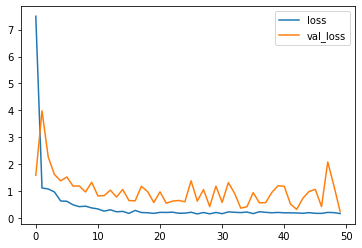

In [ ]:
losses[['loss','val_loss']].plot()

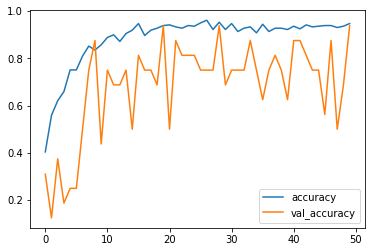

In [ ]:
losses[['accuracy','val_accuracy']].plot()

### New model after adding Conv3D layers -

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPool3D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model_2 = Sequential()

model_2.add(Conv3D(64, kernel_size=(3,3,3), activation='relu',padding='same',input_shape=(len(img_idx),img_size,img_size,3)))
model_2.add(MaxPool3D(pool_size=(2,2,2)))
model_2.add(Conv3D(128, kernel_size=(3,3,3), padding='same',activation='relu'))
model_2.add(MaxPool3D(pool_size=(2,2,2)))
model_2.add(Conv3D(256, kernel_size=(3,3,3), padding='same',activation='relu'))
model_2.add(MaxPool3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

optimiser = Adam(lr=0.001)
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 14, 120, 120, 64)  5248      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 60, 60, 64)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 60, 60, 128)    221312    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 30, 30, 128)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 3, 30, 30, 256)    884992    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 15, 15, 256)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 15, 15, 256)   

In [ ]:
history  = model_2.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,initial_epoch=0)

Source path =  /content/drive/My Drive/dataset_colab/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.0883 - accuracy: 0.3771  Source path =  /content/drive/My Drive/dataset_colab/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.54935, saving model to /content/drive/My Drive/project_models/model_init_2020-11-0606_32_45.391887/model-00001-2.08831-0.37707-1.54935-0.26000.h5
21/21 [==============================] - 3453s 164s/step - loss: 2.0883 - accuracy: 0.3771 - val_loss: 1.5493 - val_accuracy: 0.2600
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.5776
Epoch 00002: val_loss improved from 1.54935 to 1.50495, saving model to /content/drive/My Drive/project_models/model_init_2020-11-0606_32_45.391887/model-00002-1.03474-0.57764-1.50495-0.37500.h5
21/21 [==============================] - 124s 6s/step - loss: 1.0347 - accuracy: 0.5776 - val_loss: 1.5050 - val_

In [ ]:
import pandas as pd
losses = pd.DataFrame(model.history.history)

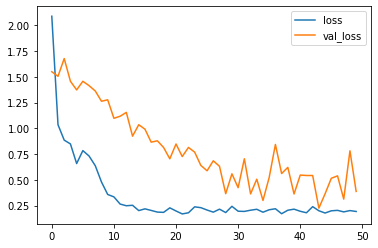

In [ ]:
losses[['loss','val_loss']].plot()

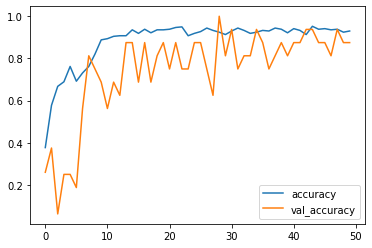

In [ ]:
losses[['accuracy','val_accuracy']].plot()

## Conv2D with Time Distributed block and LSTM

In [ ]:
#Let's take image size as 120x120
img_size = 120

#batch size as 32 
batch_size = 32

#Pickup images having below indexes from folder of 30 images for each frame -
#img_idx = [i for i in range(6,30,2)]
img_idx = [i for i in range(2,30,2)]
print(len(img_idx))

14


In [ ]:
train_generator = generator(train_path, train_doc, batch_size,img_idx)
val_generator = generator(val_path, val_doc, batch_size,img_idx)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,LSTM
from tensorflow.keras.layers import Conv2D,Conv3D, MaxPool3D, Dropout,GlobalAveragePooling2D,MaxPool2D,GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model_3 = Sequential()
model_3.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',padding='same',), input_shape=(len(img_idx),img_size,img_size,3)))
model_3.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',padding='same'))) 
model_3.add(TimeDistributed(MaxPool2D()))
#model_3.add(BatchNormalization())
model_3.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',padding='same')))
model_3.add(TimeDistributed(Conv2D(128, (3,3), activation='relu',padding='same')))
model_3.add(TimeDistributed(MaxPool2D()))
#model_3.add(BatchNormalization())
model_3.add(TimeDistributed(Conv2D(256, (3,3), activation='relu',padding='same')))
model_3.add(TimeDistributed(Conv2D(256, (3,3), activation='relu',padding='same')))
model_3.add(TimeDistributed(MaxPool2D()))
#model_3.add(TimeDistributed(Conv2D(256, (3,3), activation='relu',padding='same')))
#model_3.add(TimeDistributed(Conv2D(256, (3,3), activation='relu',padding='same')))
#model_3.add(TimeDistributed(MaxPool2D()))
model_3.add(TimeDistributed(Flatten()))
#model_3.add(BatchNormalization())
model_3.add(LSTM(256))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(.25))

model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(.25))

model_3.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

#optimiser = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#write your optimizer
optimiser = Adam(lr=0.001)
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, 14, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_58 (TimeDis (None, 14, 120, 120, 64)  36928     
_________________________________________________________________
time_distributed_59 (TimeDis (None, 14, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, 14, 60, 60, 128)   73856     
_________________________________________________________________
time_distributed_61 (TimeDis (None, 14, 60, 60, 128)   147584    
_________________________________________________________________
time_distributed_62 (TimeDis (None, 14, 30, 30, 128)   0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 14, 30, 30, 256)  

In [ ]:
history_3  = model_3.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,initial_epoch=0)

Source path =  /content/drive/My Drive/dataset_colab/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 58s 3s/step - loss: 1.6285 - accuracy: 0.2157 - val_loss: 1.6112 - val_accuracy: 0.1700
Epoch 2/50
21/21 [==============================] - 38s 2s/step - loss: 1.6079 - accuracy: 0.2464 - val_loss: 1.5985 - val_accuracy: 0.1875
Epoch 3/50
21/21 [==============================] - 34s 2s/step - loss: 1.6134 - accuracy: 0.1850 - val_loss: 1.6101 - val_accuracy: 0.0625
Epoch 4/50
21/21 [==============================] - 31s 1s/step - loss: 1.5944 - accuracy: 0.2607 - val_loss: 1.5297 - val_accuracy: 0.4375
Epoch 5/50
21/21 [==============================] - 28s 1s/step - loss: 1.5986 - accuracy: 0.2549 - val_loss: 1.6321 - val_accuracy: 0.3125
Epoch 6/50
21/21 [==============================] - ETA: 0s - loss: 1.5747 - accuracy: 0.2689
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 [============================

In [ ]:
import pandas as pd
losses = pd.DataFrame(model_3.history.history)

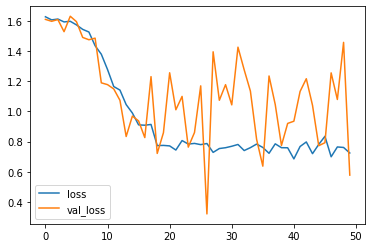

In [ ]:
losses[['loss','val_loss']].plot()

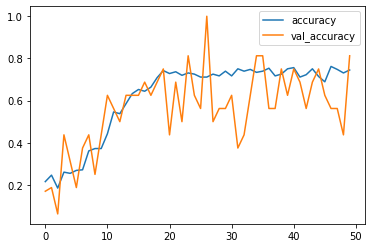

In [ ]:
losses[['accuracy','val_accuracy']].plot()

### Transfer learning (VGG16) with Time Distributed block & LSTM

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,LSTM
from tensorflow.keras.layers import Conv2D,Conv3D, MaxPool3D, Dropout,GlobalAveragePooling2D,MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications import vgg16,ResNet50

vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

for layer in vgg.layers[:-4]:
    layer.trainable = False

model_4 = Sequential()

model_4.add(TimeDistributed(vgg, input_shape=(len(img_idx),img_size,img_size,3)))

model_4.add(TimeDistributed(Flatten()))

model_4.add(BatchNormalization())

model_4.add(LSTM(256, activation='relu', return_sequences=False))

#model_4.add(BatchNormalization())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(.25))


#model_4.add(Dense(256, activation='relu'))
#model_4.add(Dropout(.25))
#model_4.add(BatchNormalization())
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(.25))

model_4.add(Dense(5, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam

#optimiser = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)#write your optimizer
optimiser = Adam(lr=0.001)
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_71 (TimeDis (None, 14, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_72 (TimeDis (None, 14, 4608)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 4608)          18432     
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               4981760   
_________________________________________________________________
dense_24 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)             

In [ ]:
history_4  = model_4.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps,
                    class_weight=None,initial_epoch=0)

Source path =  /content/drive/My Drive/dataset_colab/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - 57s 3s/step - loss: 1.5381 - accuracy: 0.4630 - val_loss: 107.9979 - val_accuracy: 0.3400
Epoch 2/50
21/21 [==============================] - 36s 2s/step - loss: 1.1249 - accuracy: 0.6605 - val_loss: 19.5190 - val_accuracy: 0.4375
Epoch 3/50
21/21 [==============================] - 34s 2s/step - loss: 0.8225 - accuracy: 0.7026 - val_loss: 19.9392 - val_accuracy: 0.3125
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.7143
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
21/21 [==============================] - 30s 1s/step - loss: 0.8282 - accuracy: 0.7143 - val_loss: 49.3523 - val_accuracy: 0.4375
Epoch 5/50
21/21 [==============================] - 28s 1s/step - loss: 0.6447 - accuracy: 0.7815 - val_loss: 12.0878 - val_accuracy: 0.3750
Epoch 6/50
21/21 [======================

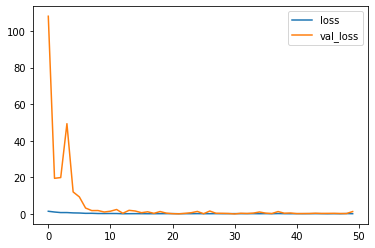

In [ ]:
losses = pd.DataFrame(model_4.history.history)
losses[['loss','val_loss']].plot()

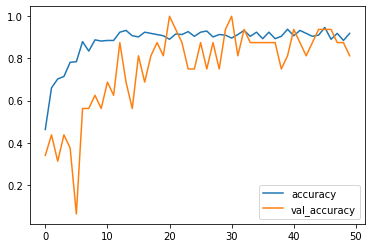

In [ ]:
losses[['accuracy','val_accuracy']].plot()

## Model evaluation

``model_2`` architecture is taken as final model and shared in the zip attachment

In [8]:
from tensorflow.keras.models import load_model

In [9]:
#this model is model_2 architecture and shared in the zip as final model -
model = load_model('/content/drive/My Drive/project_models/final_model.h5')

In [10]:
batch_size

32

In [11]:
num_val_sequences

100

In [12]:
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences//batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
val_generator = generator(val_path, val_doc, batch_size,img_idx,shuffle=False)

In [14]:
#teps_per_epoch_val = np.ceil(len(val_index) / batch_size)
pred = model.predict_generator(val_generator,steps=validation_steps, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
Source path =  /content/drive/My Drive/dataset_colab/Project_data/val ; batch size = 32
4/4 [==============================] - 515s 129s/step


In [15]:
predictions = np.argmax(pred, axis = 1)
predictions[:10]

array([3, 4, 2, 0, 2, 3, 0, 2, 2, 1])

In [31]:
predictions = np.argmax(pred, axis = 1)
predictions[:10]

array([3, 4, 2, 0, 2, 3, 0, 2, 2, 1])

In [16]:
len(predictions)

100

In [33]:
type(predictions)

numpy.ndarray

In [17]:
label = []

for i in list(val_doc):
    label.append(i.split(';')[2].strip('\n'))

In [18]:
label = np.array(label)
label = label.astype(np.int)

In [19]:
label

array([3, 4, 2, 0, 2, 3, 0, 2, 3, 1, 3, 1, 1, 0, 3, 3, 2, 1, 3, 3, 0, 2,
       2, 0, 3, 1, 2, 1, 3, 0, 3, 1, 0, 3, 3, 0, 4, 0, 1, 4, 0, 1, 2, 2,
       2, 3, 1, 4, 0, 4, 4, 2, 4, 3, 0, 2, 4, 3, 4, 1, 2, 4, 0, 2, 1, 2,
       0, 1, 3, 2, 2, 1, 3, 0, 1, 4, 4, 1, 2, 1, 3, 1, 0, 0, 4, 4, 1, 3,
       2, 4, 1, 2, 4, 0, 1, 2, 3, 1, 1, 2])

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
confusion_matrix(label,predictions)

array([[12,  2,  1,  2,  1],
       [ 1, 20,  1,  1,  0],
       [ 0,  0, 17,  4,  1],
       [ 0,  1,  2, 18,  0],
       [ 0,  0,  0,  0, 16]])

In [22]:
print(classification_report(label,predictions))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.87      0.87      0.87        23
           2       0.81      0.77      0.79        22
           3       0.72      0.86      0.78        21
           4       0.89      1.00      0.94        16

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

